In [2]:
%load_ext rpy2.ipython

In [75]:
%%R
library(phyloseq)
library(vegan)
library(dplyr)
library(ggplot2)

In [26]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom")
md = sample_data(physeq)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7770 taxa and 119 samples ]
sample_data() Sample Data:       [ 119 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 7770 taxa by 7 taxonomic ranks ]


In [36]:
%%R
otu_tab = otu_table(physeq) %>% data.frame

Error in defined[[i]] : Interrupted


In [49]:
from cogent.maths.stats.rarefaction import rarefaction
import pandas.rpy.common as com
from numpy import vstack, arange, mean
import pandas as pd

In [43]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0)

In [38]:
otu_tab = com.load_data("otu_tab")

In [60]:
%%time
dfs = {}
for sid in otu_tab.columns:
    counts = otu_tab[sid]
    x, raref_data = get_raref_vector(counts, iters=10)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data})   

CPU times: user 12min, sys: 84 ms, total: 12min
Wall time: 12min


In [61]:
d = pd.concat(dfs, axis=0)
d.reset_index(inplace=True)
d.drop(["level_1"], axis=1, inplace=True)
d.rename(columns={"level_0" : "SampleID"}, inplace=True)
d.head()

,SampleID,x,y
0,S001,10,9.8
1,S001,20,19.3
2,S001,30,28.6
3,S001,40,37.5
4,S001,50,46.1


In [62]:
d = com.convert_to_r_dataframe(d, strings_as_factors=True)
%Rpush d

In [69]:
%%R
md = sample_data(physeq) %>% data.frame %>% add_rownames("SampleID")

Joining by: "SampleID"


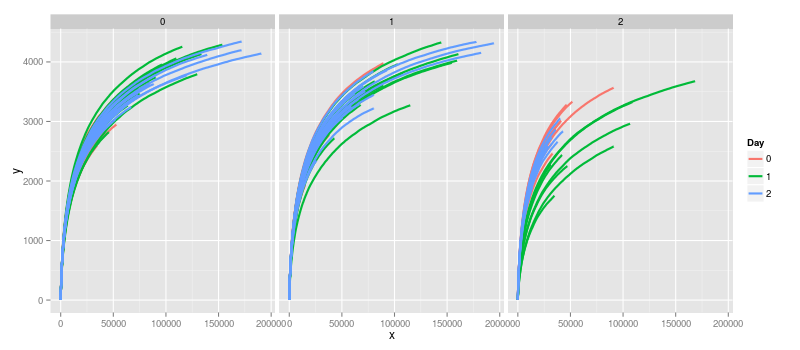

In [84]:
%%R -w 800 -h 350
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Day))

p = p + facet_grid(. ~ Amdmt)

p = p + geom_line(size = 1)

p   

Joining by: "SampleID"


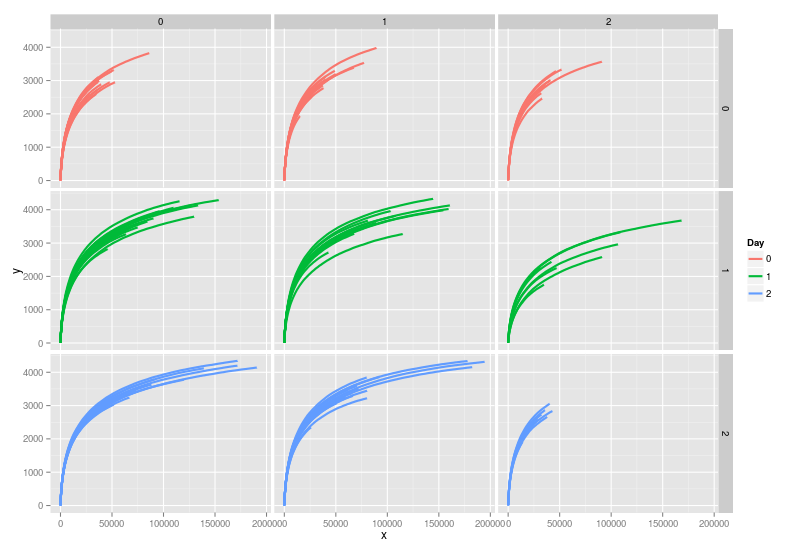

In [85]:
%%R -w 800 -h 550
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Day))

p = p + facet_grid(Day ~ Amdmt)

p = p + geom_line(size = 1)

p   